## Plan of work <a id = "plan"> </a>

[1. Downloading and preparing data](#1.)<br>
[2. Train model](#2.)<br>
[3. Final testing](#3.)<br>

In [1]:
import os
from typing import Dict

import pandas as pd
from numpy import asarray
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.notebook import tqdm

# 1. Downloading and preparing data <a id = "1."> </a>

[Back to plan](#plan)

In [2]:
PATH = "./Data"
MAX_LEN = 134
BATCH_SIZE = 128
LR = 0.003
MODEL_NAME = "distilbert-base-uncased"

In [3]:
train_data = pd.read_csv(os.path.join(PATH, "train.csv"))
train_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


### Dividing the data into training and validation samples

In [5]:
from sklearn.model_selection import train_test_split

train_split, val_test_split = train_test_split(train_data, stratify=train_data["target"], test_size=0.20, random_state=42)
val_split, test_split = train_test_split(val_test_split, stratify=val_test_split["target"], test_size=0.5, random_state=42)
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
test_split = test_split.reset_index(drop=True)

In [6]:
test_split

,qid,question_text,target
0,60ab80c4237475c3fd60,What are the best books to learn about communism?,0
1,5a103d12b4b16f9506fb,Whats are the problems facing industry media t...,0
2,445e35fa8230b34b5001,Is it worth studying ICE from NSIT?,0
3,16daaf91bd15cc60b4b8,"How did the trilogy ""The Hunger Games"" became ...",0
4,fcc86965d99359cf735c,What are the simple rules to reduce weight in ...,0
...,...,...,...
130608,3ca618614370ee3a3634,What are the causes for swollen eyes on dogs?,0
130609,a00c874d3f49cb7d940a,What benefits can be derived if marriage is a ...,0
130610,b7f8b2f6fd6a6919d06a,Someone is recording a game and have put my us...,0
130611,f915946c627af3d5383d,What is the centripetal force of an object of ...,0


In [7]:
test_split.target.value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

## Loading the tokenizer from the pre-trained model

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, truncation=True, do_lower_case=True)

## Creating datasets and dataloaders

In [9]:
class QuoraDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['question_text']
        self.targets = None
        if 'target' in dataframe:
            self.targets = dataframe['target']
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)

In [10]:
train_dataset = QuoraDataset(train_split, tokenizer, MAX_LEN)
val_dataset = QuoraDataset(val_split, tokenizer, MAX_LEN)
test_dataset = QuoraDataset(test_split.drop('target', axis=1), tokenizer, MAX_LEN)

In [11]:
train_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "num_workers": 0
}

test_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": False,
    "num_workers": 0
}

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

# 2. Train model <a id = "2."> </a>

[Back to plan](#plan)

In [12]:
from typing import Dict

import torch
from transformers import DistilBertModel
# from transformers import AutoModelForSequenceClassification


class DistilBertForClassification(torch.nn.Module):

    def __init__(self, distil_bert_path: str, config: Dict):
        super(DistilBertForClassification, self).__init__()
        self.model_name = distil_bert_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        # self.bert = AutoModelForSequenceClassification.from_pretrained(distil_bert_path)
        self.bert = DistilBertModel.from_pretrained(distil_bert_path)
        self.pre_classifier = torch.nn.Linear(768, 128)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(128, self.n_classes)
        # self.bert.tie_weights()

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        return output

In [13]:
config = {
    "num_classes": 2,
    "dropout_rate": 0.1
}
model = DistilBertForClassification(
    MODEL_NAME,
    config=config
)

for param in model.bert.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
class Trainer:
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adam(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
        return self.model.eval()

    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print(acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)
    
    def predict_probs(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(F.softmax(outputs).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = DistilBertForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer


In [15]:
trainer_config = {
    "lr": LR,
    "n_epochs": 2,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
    # "device": "cpu"
}
t = Trainer(trainer_config)
t.fit(
    model,
    train_dataloader,
    val_dataloader
)


Epoch 1/2


  0%|          | 0/8164 [00:00<?, ?it/s]

C:\Users\chern\anaconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/1021 [00:00<?, ?it/s]

0.9540547728538513
Epoch 2/2


  0%|          | 0/8164 [00:00<?, ?it/s]

  0%|          | 0/1021 [00:00<?, ?it/s]

0.9552415013313293


DistilBertForClassification(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [16]:
predictions = t.predict(test_dataloader)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
test_split["prediction"] = predictions

# 3. Final testing <a id = "3."> </a>

[Back to plan](#plan)

In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def conf_matrix(target, predicted):
    cm = confusion_matrix(y_target=target, 
                          y_predicted=predicted)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10, 10), 
                                    show_absolute=True, show_normed=True, colorbar=True)
    plt.show()

def eval_predictions(model, features_train, target_train, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрики по тестовой выборке: F1-меру, коэффициент Мэтьюса.
    '''
    predictions = model.predict(features_valid)
    print('F1-мера для класса (1): {:.2f}'. format(f1_score(target_valid, predictions)))
    print('Коэффициент Мэтьюса: {:.2f}'. format(matthews_corrcoef(target_valid, predictions)))
    print('Accuracy: {:.2f}'. format(accuracy_score(target_valid, predictions)))
    print('Balanced accuracy: {:.2f}'. format(balanced_accuracy_score(target_valid, predictions)))
    print(classification_report(target_valid, predictions, labels=[0,1]))
    roc(model, features_valid, target_valid)
    conf_matrix(target_valid, predictions)
    return model

def roc(model, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак для тестирования.
    Функция строит ROC-кривую модели, ROC-кривую случайной модели модели и высчитывает AUC-ROC.
    '''
    #расчитываем fpr и tpr
    probabilities_valid = model.predict_probs(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)
    fig, ax = plt.subplots(1, 2, figsize = (15,10))
    
    # ROC-кривая нашей модели
    ax[0].plot(fpr, tpr, linestyle='-')
    # ROC-кривая случайной модели
    ax[0].plot([0, 1], [0, 1], linestyle='--')
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    ax[0].set_xlabel('False Positive Rate') 
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC-кривая')
    
    # PR-кривая нашей модели
    ax[1].plot(recall, precision)
    ax[1].set_xlim(0,1)
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR-кривая')
    
    plt.show()
    # вычисляем AUROC
    print('AUROC: {:.2f}'.format(roc_auc_score(target_valid, probabilities_one_valid)))
    # вычисляем AUPRC
    print ('AUPRC: {:.2f}'.format(average_precision_score(target_valid, probabilities_one_valid)))

C:\Users\chern\anaconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1-мера для класса (1): 0.59
Коэффициент Мэтьюса: 0.57
Accuracy: 0.96
Balanced accuracy: 0.75
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    122532
           1       0.69      0.52      0.59      8081

    accuracy                           0.96    130613
   macro avg       0.83      0.75      0.78    130613
weighted avg       0.95      0.96      0.95    130613



C:\Users\chern\anaconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\chern\AppData\Local\Temp\ipykernel_25124\2324536983.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions.extend(F.softmax(outputs).tolist())


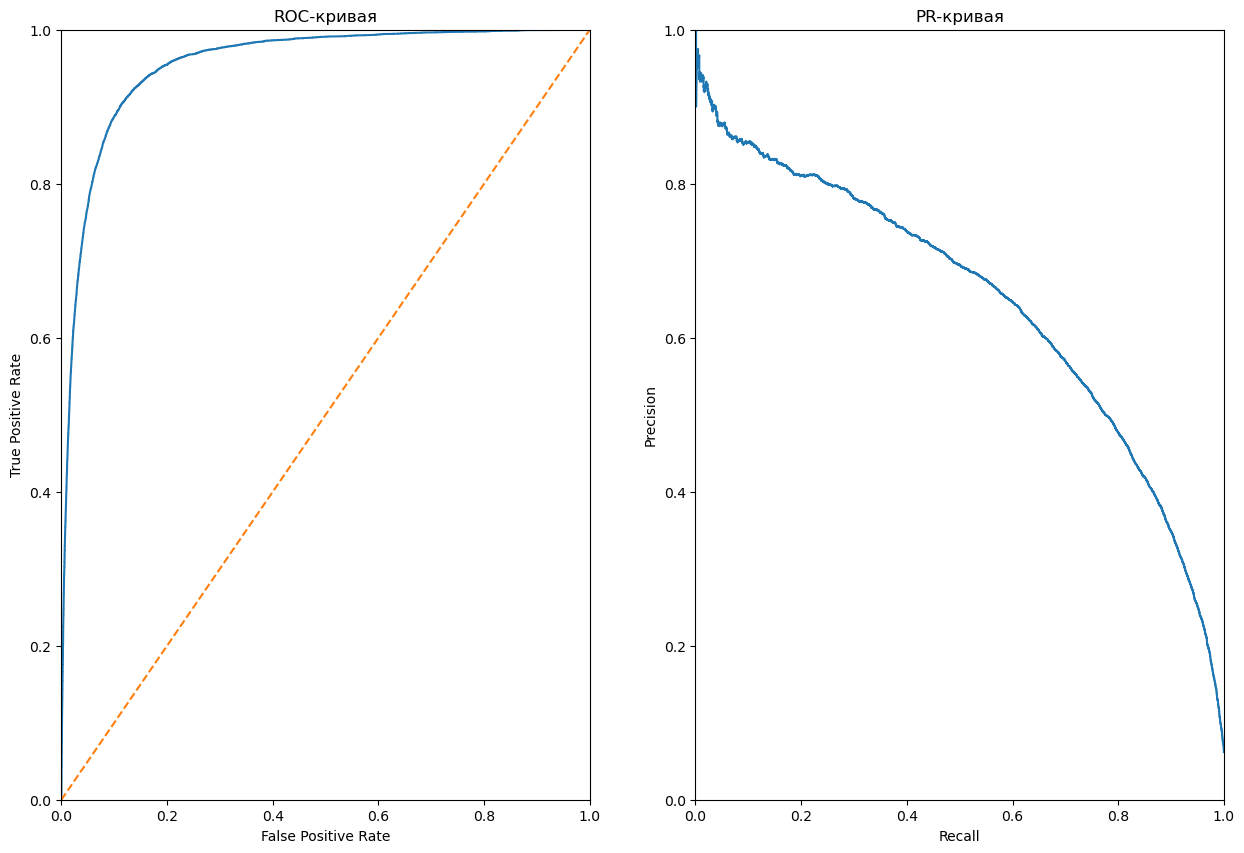

AUROC: 0.96
AUPRC: 0.65


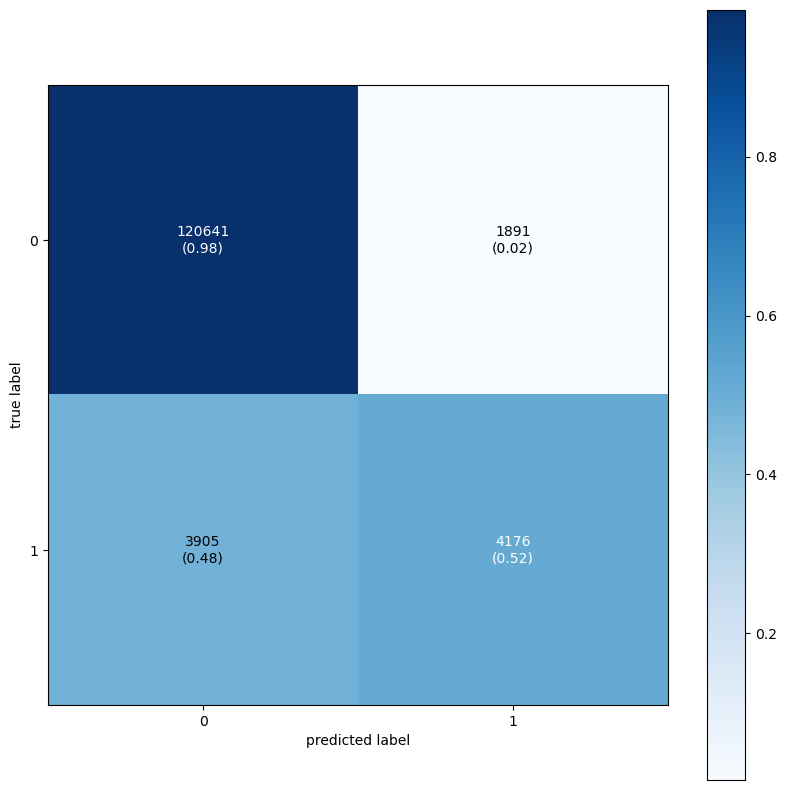

In [19]:
eval_predictions(t, train_dataloader, train_split["target"], test_dataloader, test_split["target"])